<a href="https://colab.research.google.com/github/gbiamgaurav/Time-Series-Tutorials/blob/main/Multivariate_Time_Series_using_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = "https://raw.githubusercontent.com/gbiamgaurav/ML-Datasets/main/ml_datasets/stocks.csv"

In [3]:
df = pd.read_csv(data_path)

df.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


The dataset consists of the following columns:

* Ticker: The stock symbol.
* Date: The date of the trading session.
* Open: The opening price of the stock for the trading session.
* High: The highest price of the stock during the trading session.
* Low: The lowest price of the stock during the trading session.
* Close: The closing price of the stock for the trading session.
* Adj Close: The adjusted closing price of the stock (adjusted for things like dividends and stock splits).
* Volume: The number of shares traded during the trading session.

In [4]:
## Check for missing values

df.isnull().sum()

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     248 non-null    object 
 1   Date       248 non-null    object 
 2   Open       248 non-null    float64
 3   High       248 non-null    float64
 4   Low        248 non-null    float64
 5   Close      248 non-null    float64
 6   Adj Close  248 non-null    float64
 7   Volume     248 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.6+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticker     248 non-null    object        
 1   Date       248 non-null    datetime64[ns]
 2   Open       248 non-null    float64       
 3   High       248 non-null    float64       
 4   Low        248 non-null    float64       
 5   Close      248 non-null    float64       
 6   Adj Close  248 non-null    float64       
 7   Volume     248 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 15.6+ KB


In [8]:
unique_stocks = df['Ticker'].value_counts()

unique_stocks

Ticker
AAPL    62
MSFT    62
NFLX    62
GOOG    62
Name: count, dtype: int64

In [9]:
## Checking the time range

time_range = df['Date'].min(), df['Date'].max()

print(time_range)

(Timestamp('2023-02-07 00:00:00'), Timestamp('2023-05-05 00:00:00'))


<ipython-input-14-689ccf44ce80>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


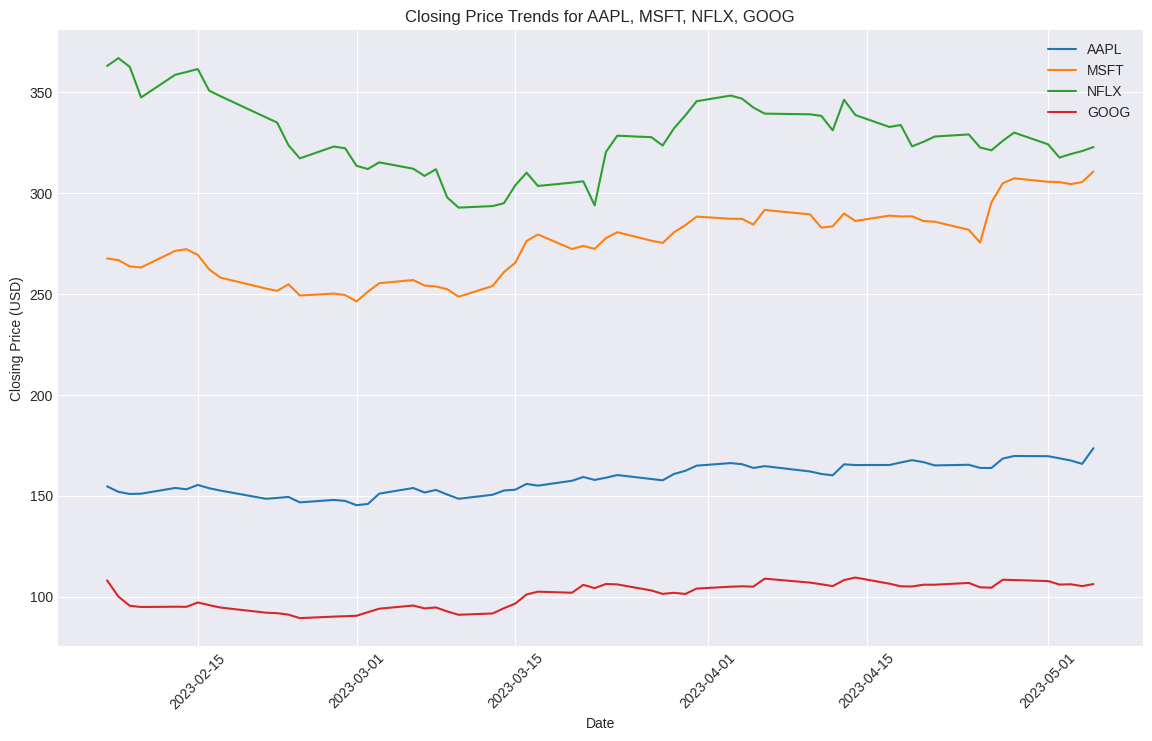

In [14]:
plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(14, 8))

for ticker in unique_stocks.index:
    subset = df[df['Ticker'] == ticker]
    ax.plot(subset['Date'], subset['Close'], label=ticker)

ax.set_title('Closing Price Trends for AAPL, MSFT, NFLX, GOOG')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show();

Moving on to model selection for forecasting, given the multivariate nature of our data, a Vector AutoRegression (VAR) model could be a suitable choice. VAR models can capture the linear interdependencies among multiple time series, which makes them a good fit for forecasting the prices of several stocks simultaneously.

Before we proceed with VAR modelling, it’s important to ensure that the time series data for each stock is stationary, as VAR models require stationarity. Stationarity means the statistical properties of the series (mean, variance) do not change over time. Let’s perform the following steps:

1. Use the Augmented Dickey-Fuller (ADF) test for each stock’s closing price.
2. Depending on the ADF test results, we may need to transform the data (e.g., by differencing) to achieve stationarity.
3. Train the VAR model and forecast the future values.

In [15]:
## Perform the ADF Test
from statsmodels.tsa.stattools import adfuller

# function to perform Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'ADF Test on "{title}"')
    result = adfuller(series, autolag='AIC')  # ADF test
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    print('\n')

# perform ADF test on the 'Close' price of each stock
for ticker in unique_stocks.index:
    series = df[df['Ticker'] == ticker]['Close']
    adf_test(series, title=ticker)

ADF Test on "AAPL"
ADF Test Statistic             -0.291693
p-value                         0.926673
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "MSFT"
ADF Test Statistic             -0.149807
p-value                         0.944246
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "NFLX"
ADF Test Statistic             -2.150926
p-value                         0.224536
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "GOOG"
ADF Test Statistic             -1.431504
p-value         

* AAPL: The p-value is 0.927, suggesting we failed to reject the null hypothesis, and the series is non-stationary.

* MSFT: With a p-value of 0.944, this series is also non-stationary.

* NFLX: The p-value is 0.225, indicating non-stationarity.

* GOOG: The p-value is 0.567, again indicating non-stationarity.

Since all series are non-stationary, we need to make them stationary before modelling. One common approach is to difference the series, which typically means to transform the data to represent the change from one period to the next rather than the absolute values.

Let’s make the series stationary by differencing the closing prices of each stock and then re-testing for stationarity:

In [16]:
# differencing the 'Close' price of each stock to make the series stationary
df['Diff_Close'] = df.groupby('Ticker')['Close'].transform(lambda x: x.diff())

for ticker in unique_stocks.index:
    series = df[df['Ticker'] == ticker]['Diff_Close'].dropna()
    adf_test(series, title=f"{ticker} - Differenced")

ADF Test on "AAPL - Differenced"
ADF Test Statistic             -5.238104
p-value                         0.000007
#Lags Used                      4.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137


ADF Test on "MSFT - Differenced"
ADF Test Statistic            -5.895024e+00
p-value                        2.864876e-07
#Lags Used                     1.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00


ADF Test on "NFLX - Differenced"
ADF Test Statistic            -8.022480e+00
p-value                        2.058613e-12
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.59319

After differencing the closing prices, the Augmented Dickey-Fuller (ADF) test results for each differenced series are:

* AAPL – Differenced: The p-value is significantly less than 0.05, indicating that we can reject the null hypothesis. The series is stationary.

* MSFT – Differenced: Similarly, the p-value is significantly low, confirming stationarity.

* NFLX – Differenced: With a very low p-value, this series is also stationary.

* GOOG – Differenced: This series is stationary as well, indicated by a very low p-value.

All differenced series are now stationary, which makes them suitable for VAR modelling for Multivariate Time Series Forecasting.

## Model Training

Since we’re working with a relatively small dataset and a short time frame, we’ll proceed with training a VAR model on the entire dataset:

In [21]:
from statsmodels.tsa.vector_ar.var_model import VAR

# prepare the dataset for VAR model
var_data = df.pivot(index='Date', columns='Ticker', values='Diff_Close').dropna()

model = VAR(var_data)
model_fitted = model.fit(ic='aic')

forecast_steps = 5

forecasted_values = model_fitted.forecast(var_data.values[-model_fitted.k_ar:], steps=forecast_steps)

forecasted_df = pd.DataFrame(forecasted_values, index=pd.date_range(start=var_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=var_data.columns)

for column in forecasted_df.columns:
    forecasted_df[column] = (df.groupby('Ticker')['Close'].last()[column] + forecasted_df[column].cumsum())

print(forecasted_df)

Ticker            AAPL        GOOG        MSFT        NFLX
2023-05-06  174.369001  113.624024  320.179608  327.604320
2023-05-07  169.684437  104.915080  318.416783  342.704109
2023-05-08  168.190894  107.828473  329.210732  367.542312
2023-05-09  160.836027   99.287041  326.849012  348.088074
2023-05-10  167.645928  101.392914  317.986680  387.059442


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The forecasted closing prices for each stock over the next 5 days have been successfully calculated. These forecasts reverse the differencing to present the expected closing prices in their original scale. To wrap up, we’ll visualize the historical closing prices along with the forecasted prices for each stock on a single graph. This visualization will help us understand the forecast in the context of recent trends.

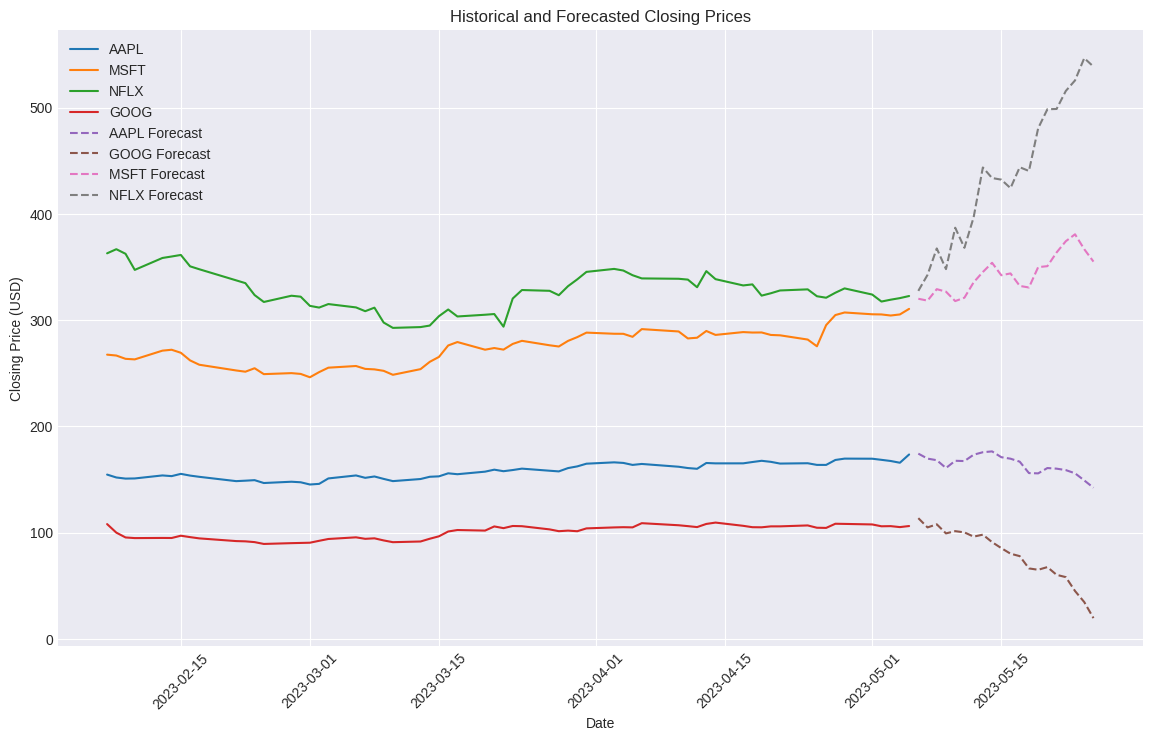

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))

# plot historical closing prices for each stock
for ticker in unique_stocks.index:
    historical_data = df[df['Ticker'] == ticker]
    ax.plot(historical_data['Date'], historical_data['Close'], label=ticker)

# plot the forecasted closing prices
for column in forecasted_df.columns:
    ax.plot(forecasted_df.index, forecasted_df[column], label=f'{column} Forecast', linestyle='--')

ax.set_title('Historical and Forecasted Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show();